# Importing packages, modules and data

In [0]:
import sys
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from google.colab import files
import ipywidgets as widg
from ipywidgets import interact, interact_manual

In [2]:
!git clone https://github.com/FBosler/Medium-Data-Exploration.git

Cloning into 'Medium-Data-Exploration'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [0]:
dfinvoices = pd.read_csv("/content/Medium-Data-Exploration/invoices.csv")
dfoleads = pd.read_csv("/content/Medium-Data-Exploration/order_leads.csv")
dfsales = pd.read_csv("/content/Medium-Data-Exploration/sales_team.csv")

# First Overview


In [4]:
# Printing sampled rows of the dataframes

@interact_manual
def print_sample(x=['invoices', 'order leads', 'sales'], n=(0,10,1)):
  d = {'invoices': dfinvoices, 
       'order leads': dfoleads,
       'sales': dfsales}
  return d[x].sample(n)

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [5]:
# Describing each of the 3 dataframes

@interact_manual
def print_sample(x=['invoices', 'order leads', 'sales']):
  d = {'invoices': dfinvoices, 
       'order leads': dfoleads,
       'sales': dfsales}
  return d[x].describe(include='all')

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [6]:
# Verifying that there is no null value on the 3 dataframes

@interact_manual
def print_msno(x=['invoices', 'order leads', 'sales'],\
               y=[ 'bars','heatmap', 'matrix']):
  d = {'invoices': dfinvoices, 'order leads': dfoleads,'sales': dfsales}
  if y=="heatmap":
    return msno.heatmap(d[x],figsize=(8,3))
  elif y=="matrix":
    return msno.matrix(d[x],figsize=(8,3))
  else:
    return msno.bar(d[x],figsize=(8,3))

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

In [7]:
# Checking the format of data

@interact_manual
def check_dtypes(x=['invoices', 'order leads', 'sales']):
  d = {'invoices': dfinvoices, 'order leads': dfoleads,'sales': dfsales}
  return d[x].dtypes

interactive(children=(Dropdown(description='x', options=('invoices', 'order leads', 'sales'), value='invoices'…

# Formatting the data

In [0]:
# Checking and modifying format of the dates

dfoleads["Date"] = pd.DatetimeIndex(dfoleads["Date"])
dfinvoices["Date of Meal"] = pd.DatetimeIndex(dfinvoices["Date of Meal"])

In [0]:
# Splitting "participants", getting the nb of part. and their list for each meal

def split_part(long_string):
  _=long_string.split(sep='\n')
  _=[s.strip("\"'[] ").split(sep="' '") for s in _]
  return list(itertools.chain.from_iterable(_))


dfinvoices.insert(4, "Participants List",\
                  dfinvoices["Participants"].apply(split_part))
dfinvoices.insert(5, "Number of Participants",\
                  dfinvoices["Participants List"].apply(len))

In [10]:
# Are the Sales Rep considered as participants of the meal ?

li_sales_rep = list(dfsales["Sales Rep"].unique())
ser = dfinvoices["Participants List"]
li_temp = [ser.str.contains(s).sum() for s in li_sales_rep]
np.histogram(li_temp) # --> No

(array([  0,   0,   0,   0,   0, 499,   0,   0,   0,   0]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]))

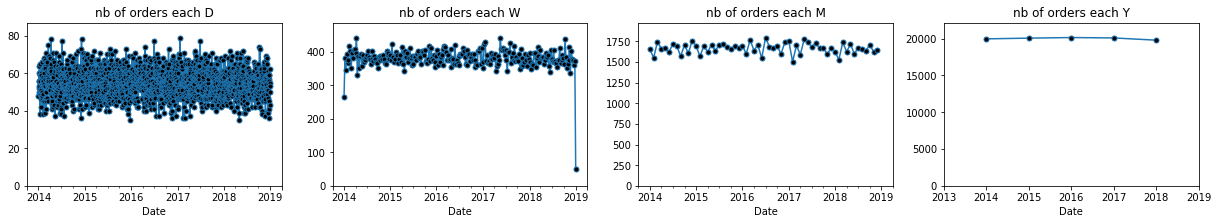

In [11]:
# Nb of order leads through time (day, week, month, year)

fig, axs = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(21,3)
fig.subplots_adjust(wspace=0.2)
for i,per in enumerate(['D', 'W', 'M', 'Y'],0):
  ser = dfoleads.groupby(pd.Grouper(key='Date',freq=per)).size()
  ser.plot(ax=axs[i], ms=5, marker='o', mfc='k', ls='-')
  axs[i].set(xlim=('2013-10-01','2019-04-01'),ylim=(0,max(ser)*1.1))
  axs[i].set_title("nb of orders each "+per)

Constant frequency of order leads from 2014 to 2019.

NameError: ignored

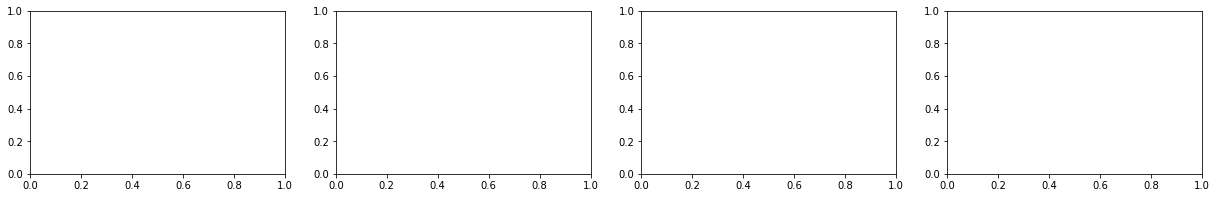

In [12]:
# Value of order leads through time (day, week, month, year)
#  total vs. converted vs. not converted

fig, axs = plt.subplots(nrows=1, ncols=4)
fig.set_size_inches(21,3)
fig.subplots_adjust(wspace=0.2)
f_roll = lambda x: x.rolling(3, min_periods=1).mean()
for i,per in enumerate(['D', 'W', 'M', 'Y'],0):
  gb = dfoleads.groupby(pd.Grouper(key='Date',freq=per))
  ser_c = gb.apply(sum_val_c_or_d, True)
  ser_d = gb.apply(sum_val_c_or_d, False)
  if per in ['D', 'W']:
    f_roll(ser_c).plot(ax=axs[i])
    # axs[i].annotate('coucou',xy=(0, 0))
    f_roll(ser_d).plot(ax=axs[i]) 
    (f_roll(ser_c)+f_roll(ser_d)).plot(ax=axs[i]) 
  else:
    ser_c.plot(ax=axs[i],marker='o')
    ser_d.plot(ax=axs[i],marker='o')
    (ser_c+ser_d).plot(ax=axs[i],marker='o') #ms=5, marker='o', mfc='k', ls='-'
  axs[i].set(xlim=('2013-10-01','2019-04-01'))
  axs[i].set_title("Amount "+per)

Constant value at stake with the order leads.

In April 2017, value of the converted order leads is going down. As we've noticed before, the nb of orders remains the same. Therefore, a drop in the conversion rate is to blame.

In [0]:
# Mean conv. rate, dismissed commands and confirmed commands on 30 rolling days
def mean_val_c_or_d(df, c_or_d):
  col_Conv = df['Converted'] if c_or_d else 1-df['Converted']
  return np.mean(df['Order Value']*col_Conv)

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20,3)
n_roll = 30
gb = dfoleads.groupby(pd.Grouper(key='Date',freq='D'))
conv_r_mean = gb['Converted'].mean().rolling(n_roll).mean()
val_c = gb.apply(mean_val_c_or_d, True).rolling(n_roll).mean()
val_d = gb.apply(mean_val_c_or_d, False).rolling(n_roll).mean()

# X = (val_c.index). ###### datetime to number ???????
# Y = np.array((val_c+val_d).values) # values converts it into a numpy array
# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(X, Y)  # perform linear regression
# Y_pred = linear_regressor.predict(X)  # make predictions

ax = plt.gca()
ax.stackplot(val_c.index, [val_c.values, val_d.values], labels=['confirmed commands', 'dismissed commands'])
ax.plot(val_c+val_d, label='total value of order leads')
ax.legend(loc='center right')
ax.set_title(f"Mean value of Commands ({n_roll} rolling days)"+per)
plt.show()

Same conclusion as above, with average on 30 rolling days.

In [0]:
# What about the evolution of the number of meals, number of participants,
# price of the meals through time ?